In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import sys

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

In [ ]:
is_in_colab = True

if(sys.platform == 'linux'):
  print('Using Ramdisk')
  if(is_in_colab):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    
    if(not os.path.isfile('/content/data.zip')):
      !cp -r "/content/drive/My Drive/Machine Learning/deliver/DeepLearning/data.zip" /content/
    if(not os.path.exists('/content/ramdisk/')):
      !mkdir /content/ramdisk/
    if(not os.path.exists('/content/ramdisk/data/')):
      !mount -t tmpfs -o size=500m tmpfs /content/ramdisk
      !unzip /content/data.zip -d /content/ramdisk/

    dir_data = '/content/ramdisk/data'
    dir_save = '/content/drive/My Drive/Machine Learning/deliver/DeepLearning/'
  else:
    if(not os.path.exists('./ramdisk/')):
      !mkdir /content/ramdisk/

    if(not os.path.exists('/content/ramdisk/data/')):
      !mount -t tmpfs -o size=500m tmpfs /content/ramdisk
      !unzip ./data.zip -d ./ramdisk/
    
    dir_data = 'ramdisk/data'
    dir_save = './'
else:
  dir_data = 'data'
  dir_save = './'

dir_train = 'Train'
dir_test = 'Test'

Streaming output truncated to the last 5000 lines.
  inflating: /content/ramdisk/data/Train/5/00005_00053_00015.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00016.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00017.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00018.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00019.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00020.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00021.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00022.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00023.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00024.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00025.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00026.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00027.png  
  inflating: /content/ramdisk/data/Train/5/00005_00053_00028.png  
  inflating

In [ ]:
train_csv = os.path.join(dir_data, 'Train.csv')
test_csv = os.path.join(dir_data, 'Test.csv')
meta_csv = os.path.join(dir_data, 'Meta.csv')

df_train_csv = pd.read_csv(train_csv, dtype=object)
df_test_csv = pd.read_csv(test_csv, dtype=object)
df_meta_csv = pd.read_csv(meta_csv, dtype=object)

In [ ]:
#because the min of width and height are all 25, in both train and test
#VGG16 min size is 32
#target_size = (25,25)
target_size = (32,32)
class_size = df_meta_csv['ClassId'].count()
validation_rate = 0.25
training_rate = 1.0 - validation_rate
batch_size = 32
learning_rate = 0.001

## Module Create

In [ ]:
conv_base= VGG16(weights='imagenet',
                    include_top=False,
                    input_shape = (target_size[0],target_size[1],3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(512,activation='relu'))
model1.add(layers.Dense(class_size,activation='softmax'))

epochs1 = 30
conv_base.trainable = False
opt1 = optimizers.Adam(lr=learning_rate, decay=learning_rate / (epochs1 * 0.5))
model1.compile(loss="categorical_crossentropy",
                optimizer=opt1,
                metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 43)                22059     
                                                                 
Total params: 14,999,403
Trainable params: 284,715
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.BatchNormalization())
model2.add(layers.Dense(512,activation='relu'))
model2.add(layers.Dropout(rate=0.5))
model2.add(layers.Dense(class_size,activation='softmax'))

epochs2 = 30
conv_base.trainable = False
opt2 = optimizers.Adam(lr=learning_rate, decay=learning_rate / (epochs2 * 0.5))
model2.compile(loss="categorical_crossentropy",
                optimizer=opt2,
                metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 43)                22059     
                                                      

In [ ]:
model3 = models.Sequential([    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(target_size[0],target_size[1],3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    
    layers.Dense(43, activation='softmax')
])

epochs3 = 30
conv_base.trainable = False
opt3 = optimizers.Adam(lr=learning_rate, decay=learning_rate / (epochs3 * 0.5))
model3.compile(loss="categorical_crossentropy",
                optimizer=opt3,
                metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)      

In [ ]:
model4 = models.Sequential([    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(target_size[0],target_size[1],3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    
    layers.Dense(43, activation='softmax')
])

epochs4 = 30
conv_base.trainable = False
opt4 = optimizers.Adam(lr=learning_rate, decay=learning_rate / (epochs4 * 0.5))
model4.compile(loss="categorical_crossentropy",
                optimizer=opt4,
                metrics=['accuracy'])  
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                  

## Load Test Data

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_data = test_datagen.flow_from_dataframe(
    dataframe = df_test_csv,
    directory = dir_data,
    x_col = 'Path',
    y_col = 'ClassId',
    target_size = target_size,
    class_mode="categorical")

Found 12630 validated image filenames belonging to 43 classes.


## Load saved weight

In [ ]:
model1.load_weights(os.path.join(dir_save, 'module1_weight'))

In [ ]:
test_loss, test_acc = model1.evaluate(test_data)
print('\ntest acc :\n', test_acc)

395/395 [==============================] - 151s 380ms/step - loss: 3.1560 - accuracy: 0.5337

test acc :
 0.5337291955947876


In [ ]:
model2.load_weights(os.path.join(dir_save, 'module2_weight'))
test_loss, test_acc = model2.evaluate(test_data)
print('\ntest acc :\n', test_acc)

395/395 [==============================] - 148s 374ms/step - loss: 2.3251 - accuracy: 0.5116

test acc :
 0.5116389393806458


In [ ]:
model3.load_weights(os.path.join(dir_save, 'module3_weight'))
test_loss, test_acc = model3.evaluate(test_data)
print('\ntest acc :\n', test_acc)

395/395 [==============================] - 17s 42ms/step - loss: 0.1438 - accuracy: 0.9728

test acc :
 0.9728424549102783


In [ ]:
model4.load_weights(os.path.join(dir_save, 'module4_weight'))
test_loss, test_acc = model4.evaluate(test_data)
print('\ntest acc :\n', test_acc)

395/395 [==============================] - 19s 48ms/step - loss: 0.3284 - accuracy: 0.9688

test acc :
 0.9688044190406799


## History of training

In [ ]:
import pickle

file = open(os.path.join(dir_save, 'history1'), 'rb')
history1 = pickle.load(file)
file.close()

file = open(os.path.join(dir_save, 'history2'), 'rb')
history2 = pickle.load(file)
file.close()


file = open(os.path.join(dir_save, 'history3'), 'rb')
history3 = pickle.load(file)
file.close()

file = open(os.path.join(dir_save, 'history4'), 'rb')
history4 = pickle.load(file)
file.close()

In [ ]:
def print_history(history):
  fig, axs = plt.subplots(1, 2)
  axs[0].plot(pd.DataFrame(history)[['accuracy', 'val_accuracy']])
  axs[1].plot(pd.DataFrame(history)[['loss', 'val_loss']])

  axs[0].grid(True)
  axs[0].set_ylim(0, 1)
  axs[0].set_title('Accuracy vs. epochs')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')

  axs[1].grid(True)
  axs[1].set_ylim(0, 4)
  axs[1].set_title('Loss vs. epochs')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')

  fig.tight_layout()
  plt.show()


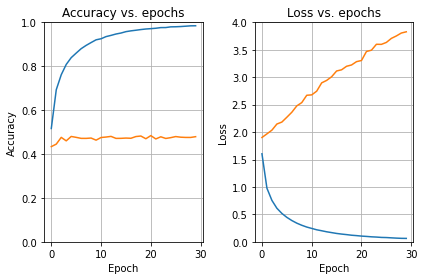

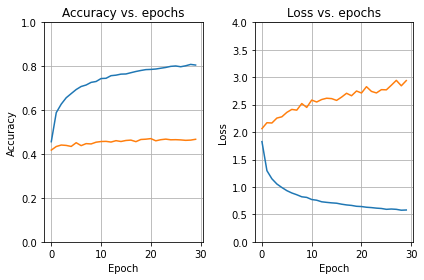

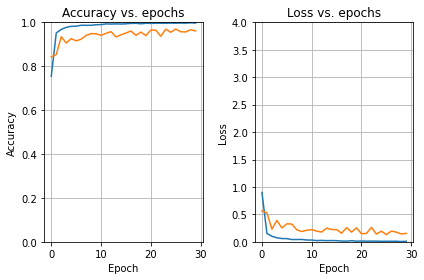

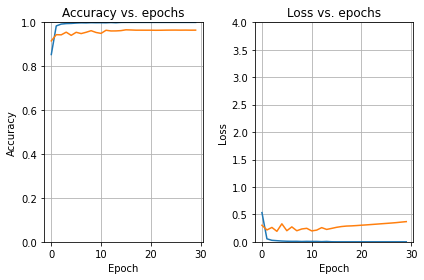

In [ ]:
print_history(history1)
print_history(history2)
print_history(history3)
print_history(history4)

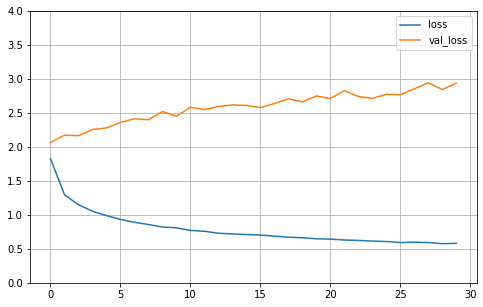